In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
import sys

In [4]:
print(sys.executable)

/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/bin/python


In [5]:
!python --version

Python 3.10.2


### Create functions for all steps involved in complete model training lifecycle

In [6]:
def load_data(path):
    return pd.read_csv(path)

In [7]:
data = load_data("https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [8]:
def data_cleaning(data):
    print('na values available in data\n')
    print(data.isna().sum())
    data = data.dropna()
    print('After dropping na values \n')
    print(data.isna().sum())
    return data

In [9]:
def preprocessing(data):
    data['education'] = np.where(data['education'] =='basic.9y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.6y', 'Basic', data['education'])
    data['education'] = np.where(data['education'] == 'basic.4y', 'Basic', data['education'])
    
    cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
    for var in cat_vars:
        cat_list = 'var'+ '_' + var
        cat_list = pd.get_dummies(data[var], prefix=var)
        data1 = data.join(cat_list)
        data = data1
        
    data_vars = data.columns.values.tolist()
    to_keep = [i for i in data_vars if i not in cat_vars]
    final_data = data[to_keep]
    
    final_data.columns = final_data.columns.str.replace(".", "_")
    final_data.columns = final_data.columns.str.replace(" ", "_")
    return final_data

In [27]:
def df_train_test_split(final_data):
    X = final_data.loc[:, final_data.columns != 'y']
    y = final_data.loc[:, final_data.columns == 'y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=47)
    return X_train, X_test, y_train, y_test

In [34]:
def over_sampling_target_class(X_train, y_train):
    from imblearn.over_sampling import SMOTE
    os = SMOTE(random_state=0)
    
    columns = X_train.columns
    os_data_X, os_data_y = os.fit_resample(X_train, y_train)
    
    os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
    os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])
    print("length of over-sampled data is:", len(os_data_X))
    print("length of no subscription in oversampled data", len(os_data_y[os_data_y['y']==0]))
    print("Number of subscription", len(os_data_y[os_data_y["y"]==1]))
    print("Proportion of no subscription data in oversampled data is", len(os_data_y[os_data_y['y']==0])/len(os_data_X))
    print("Proportion of subscription data in oversampled data is", len(os_data_y[os_data_y['y']==1])/len(os_data_X))
    
    X_train = os_data_X
    y_train = os_data_y['y']
    
    return X_train, y_train

In [12]:
def training_basic_classifier(X_train, y_train):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100)
    return model.fit(X_train, y_train)
    

In [13]:
def predict_on_test_data(model, X_test):
    return model.predict(X_test)

In [14]:
def predict_prob_on_test_data(model, X_test):
    return model.predict_proba(X_test)

In [15]:
def get_metrics(y_true, y_pred, y_pred_proba):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
    acc= accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    entropy = log_loss(y_true, y_pred_proba)
    return {'accuracy': round(acc, 2), 'precision': round(prec, 2), 'recall': round(recall, 2), 'entropy': round(entropy, 2)}

In [49]:
def create_roc_auc_plot(clf, X_data, y_data):
    import matplotlib.pyplot as plt
    from sklearn import metrics
    metrics.plot_roc_curve(clf, X_data, y_data)
    plt.savefig('roc_auc_curve.png')

In [17]:
def create_confusion_metrics_plot(clf, X_test, y_test):
    import matplotlib.pyplot as plt
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(clf, X_test, y_test)
    plt.savefig('confusion_matrix.png')

In [63]:
def hyper_parameter_tuning(X_train, y_train):
    n_estimators = [5, 21, 51, 101]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 120, num=12)]
    min_samples_split = [2,  6, 10]
    min_samples_leaf = [1, 3, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap
                  }
    
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier
    classifier = RandomForestClassifier()
    model_tuning = RandomizedSearchCV(estimator = classifier, param_distributions=random_grid, 
                                     n_iter = 100, cv=5, verbose=2, random_state=35, n_jobs=-1
                                    )
    model_tuning.fit(X_train, y_train)
    print("Random Grid:", random_grid, '\n')
    
    print('Best Parameters:', model_tuning.best_params_, '\n')
    best_params = model_tuning.best_params_
    
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']
    
    model_tuned= RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                        min_samples_leaf= min_samples_leaf, max_features=max_features,
                                        max_depth=max_depth, bootstrap=bootstrap)
    model_tuned.fit(X_train, y_train)
    return model_tuned, best_params

In [20]:
cleaned_data = data_cleaning(data=data)

na values available in data

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
After dropping na values 

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [21]:
final_data = preprocessing(cleaned_data)

/var/folders/xf/_6m_tb052fn5p84tlt773rqr0000gn/T/ipykernel_10024/3824108937.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data.columns = final_data.columns.str.replace(".", "_")


In [28]:
X_train, X_test, y_train, y_test = df_train_test_split(final_data)

In [35]:
X_train, y_train = over_sampling_target_class(X_train, y_train)

length of over-sampled data is: 51166
length of no subscription in oversampled data 25583
Number of subscription 25583
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


In [36]:
model = training_basic_classifier(X_train, y_train)

In [38]:
y_pred = predict_on_test_data(model=model, X_test=X_test)

In [39]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
y_pred_prob = predict_prob_on_test_data(model, X_test)

In [41]:
y_pred_prob

array([[0.99, 0.01],
       [0.99, 0.01],
       [0.89, 0.11],
       ...,
       [1.  , 0.  ],
       [0.71, 0.29],
       [1.  , 0.  ]])

In [42]:
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

In [43]:
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.49, 'entropy': 0.2}


/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


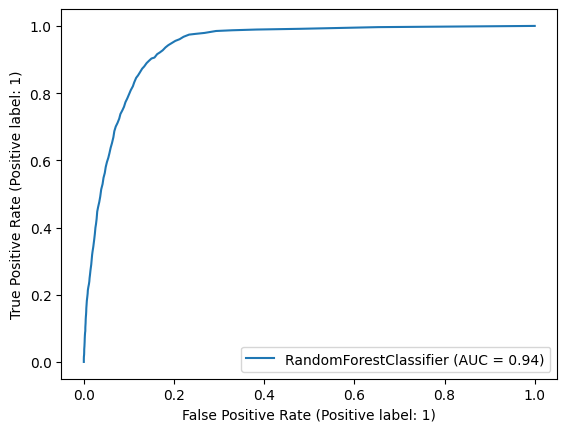

In [50]:
create_roc_auc_plot(model, X_test, y_test)

/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


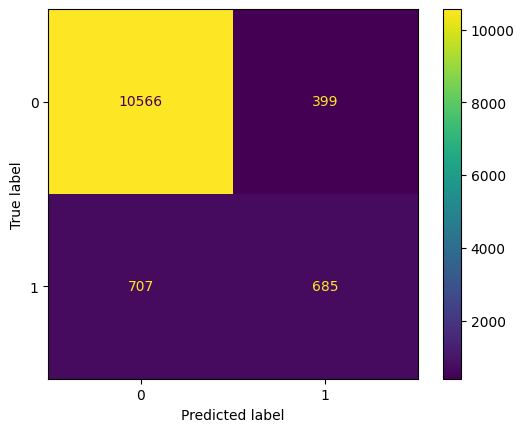

In [51]:
create_confusion_metrics_plot(model, X_test, y_test)

## ML FLow work Starts from here

### Functions to create an experiment in MLFlow and log parameters, metrics and artifacts files like images etc

In [57]:
def create_experiment(experiment_name, run_name, run_metrics, model, confusion_matrix_path=None, 
                     roc_auc_plot_path=None, run_params=None):
    import mlflow
    #mlflow.set_tracking_uri("https://localhost:5000) # Document this line if you want to use any database like sqlite
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run():
        
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param, run_params[param])
        
        for metric in run_metrics:
            mlflow.log_metric(metric, run_metrics[metric])
        
        mlflow.sklearn.log_model(model, "model")
        
        if not confusion_matrix_path == None:
            mlflow.log_artifact(confusion_matrix_path, 'confusion_matrix')
        
        if not roc_auc_plot_path == None:
            mlflow.log_artifact(roc_auc_plot_path, "roc_auc_plot")
        
        mlflow.set_tag("tag1", "RandomForest")
        mlflow.set_tags({"tag2": "Randomized Search CV", "tag3": "Production"})
        mlflow.sklearn.load_model(model, "model", registered_model_name = "classifier")
    
    print("Run - %s is logged to Experiment - %s" %(run_name, experiment_name))

In [58]:
experiment_name = "Experiment_1"
run_name = "term_deposit"
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)
print(run_metrics)

{'accuracy': 0.91, 'precision': 0.63, 'recall': 0.49, 'entropy': 0.2}


In [59]:
create_experiment(experiment_name, run_name, run_metrics, model, 'confusion_matrix.png', 'roc_auc_curve.png')

2023/08/23 17:38:24 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_1' does not exist. Creating a new experiment.


Run - term_deposit is logged to Experiment - Experiment_1


/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Create another experiment after tuning hyperparameters and log the best set of parameters fow which model gives the optimal performance


In [66]:
import mlflow
experiment_name = "optimized model"
run_name = "Random_Search_CV_Tuned_Model"

model_tuned, best_params = hyper_parameter_tuning(X_train, y_train)
run_params = best_params

y_pred = predict_on_test_data(model_tuned, X_test)
y_pred_prob = predict_prob_on_test_data(model_tuned, X_test)
run_metrics = get_metrics(y_test, y_pred, y_pred_prob)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed

Random Grid: {'n_estimators': [5, 21, 51, 101], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120], 'min_samples_split': [2, 6, 10], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True, False]} 

Best Parameters: {'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False} 



/Users/harendrakumar/.local/share/virtualenvs/ETL-6mpoCg48/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [67]:
run_metrics

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.53, 'entropy': 0.2}

In [68]:
for param in run_params:
    print(param, run_params[param])

n_estimators 21
min_samples_split 2
min_samples_leaf 3
max_features auto
max_depth 100
bootstrap False


In [69]:
create_experiment(experiment_name, run_name, run_metrics, model_tuned, 'confusion_matrix.png', 'roc_auc_curve.png', run_params)

2023/08/23 20:52:03 INFO mlflow.tracking.fluent: Experiment with name 'optimized model' does not exist. Creating a new experiment.


Run - Random_Search_CV_Tuned_Model is logged to Experiment - optimized model
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=21; total time=   1.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=21; total time=   1.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=101; total time=   4.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=51; total time=   2.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_esti